# BTC/USD Price Forecast Model
Analysis to determine the ideal model to predict future BTC prices.

In [324]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [322]:
pip install pmdarima

  Using cached pmdarima-1.8.2-cp39-cp39-win_amd64.whl (596 kB)
  Using cached joblib-1.0.1-py3-none-any.whl (303 kB)
  Using cached urllib3-1.26.6-py2.py3-none-any.whl (138 kB)
  Using cached numpy-1.19.5-cp39-cp39-win_amd64.whl (13.3 MB)
ERROR: Could not install packages due to an OSError: [WinError 2] The system cannot find the file specified: 'C:\\Python39\\Scripts\\f2py.exe' -> 'C:\\Python39\\Scripts\\f2py.exe.deleteme'

You should consider upgrading via the 'C:\Python39\python.exe -m pip install --upgrade pip' command.

  Using cached Cython-0.29.24-cp39-cp39-win_amd64.whl (1.7 MB)
  Using cached scikit_learn-0.24.2-cp39-cp39-win_amd64.whl (6.9 MB)
  Using cached threadpoolctl-2.2.0-py3-none-any.whl (12 kB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.0
    Uninstalling numpy-1.21.0:
      Successfully uninstalled numpy-1.21.0
  Rolling back uninstall of numpy
  Moving to c:\python39\lib\site-packages\numpy-1.21.0.dist-info\
   from C:\Python39\Lib\sit

## Helper Functions

In [177]:
def adf_test(series):
    result = adfuller(series)
    print("ADF Statistic: %f" % result[0])
    print("p-value: %f" % result[1])

## Import Data

In [245]:
btc_usd_df = pd.read_csv("BTC-USD_1y200101.csv", parse_dates=[0], index_col=0, squeeze=True, date_parser=lambda s: datetime.strptime(s, "%Y-%m-%d")).dropna()
btc_usd_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,7200.174316,1.856566e+10
2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,6985.470215,2.080208e+10
2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,7344.884277,2.811148e+10
2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,7410.656738,1.844427e+10
2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,7411.317383,1.972507e+10


In [246]:
btc_usd_close_df = btc_usd_df.drop(columns=["Open", "High", "Low", "Adj Close", "Volume"]).dropna()
btc_usd_close_df.head()

,Close
Date,
2020-01-01,7200.174316
2020-01-02,6985.470215
2020-01-03,7344.884277
2020-01-04,7410.656738
2020-01-05,7411.317383


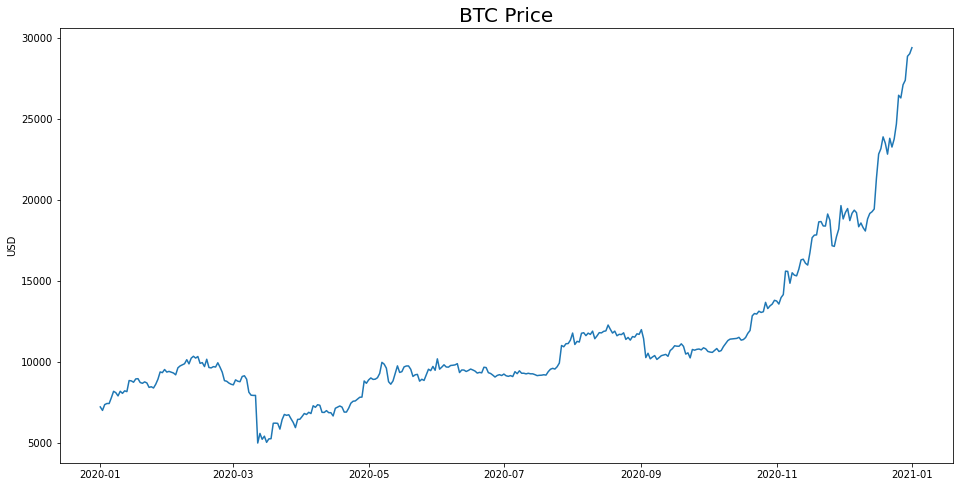

In [247]:
plt.figure(figsize=(16,8))
plt.title("BTC Price", fontsize=20)
plt.ylabel("USD")
plt.plot(btc_usd_close_df.Close)

## Normalization

In [248]:
mean, std = btc_usd_close_df.Close.mean(), btc_usd_close_df.Close.std()

# z-score normalization
btc_usd_close_df['Close_n'] = (btc_usd_close_df.Close - mean) / std

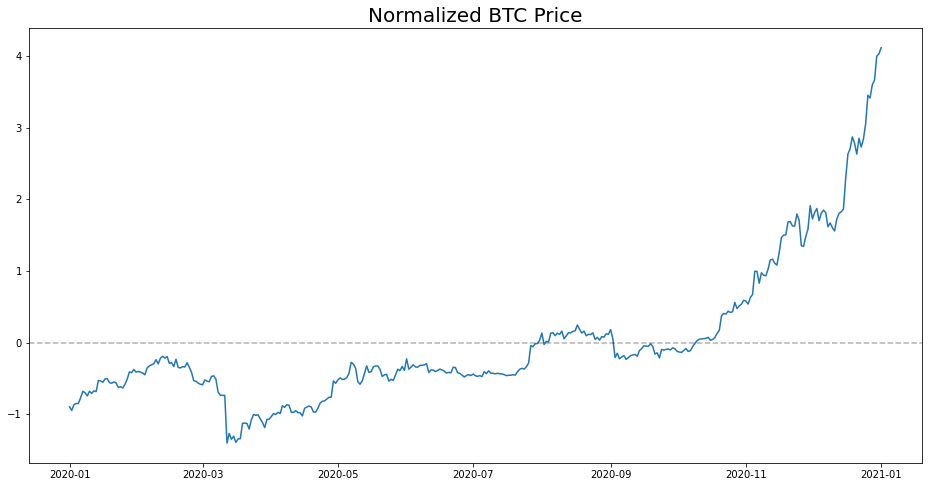

In [249]:
plt.figure(figsize=(16,8))
plt.title("Normalized BTC Price", fontsize=20)
plt.plot(btc_usd_close_df.Close_n)
plt.axhline(y=0, linestyle='--', color='k', alpha=0.3)

## Stationarize

### First Difference

In [250]:
btc_usd_close_df['Diff_1'] = btc_usd_close_df.Close_n.diff().dropna()

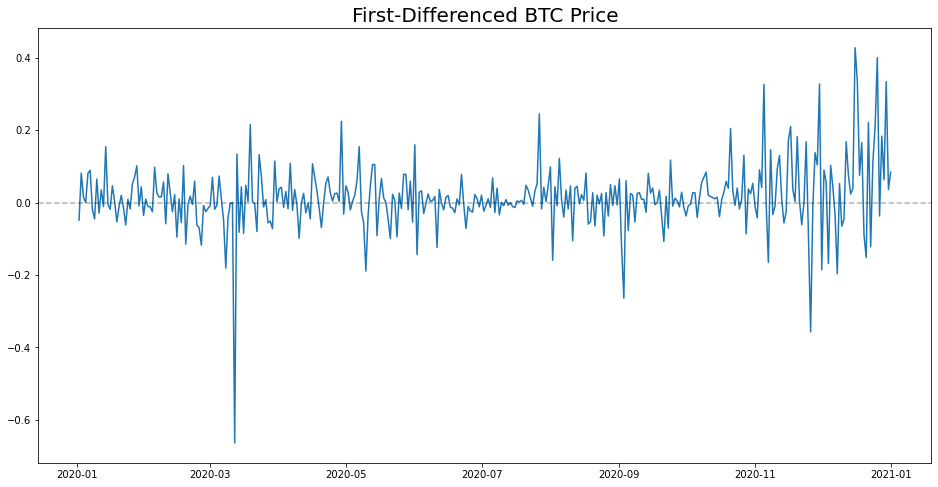

In [251]:
plt.figure(figsize=(16,8))
plt.title("First-Differenced BTC Price", fontsize=20)
plt.plot(btc_usd_close_df.Diff_1)
plt.axhline(y=0, linestyle='--', color='k', alpha=0.3)

### ADF-Test for First-Differenced BTC Price Series

In [252]:
adf_test(btc_usd_close_df.Diff_1.dropna())

ADF Statistic: -2.654813
p-value: 0.082189


### ACF for First-Differenced BTC Price

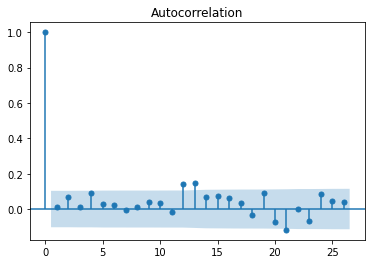

In [253]:
plot_acf(btc_usd_close_df.Diff_1.dropna())
plt.show()

### PACF for First-Differenced BTC Price

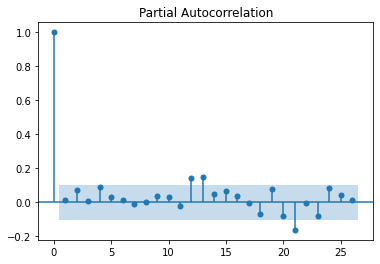

In [254]:
plot_pacf(btc_usd_close_df.Diff_1.dropna())
plt.show()

### Volatility Adjustment

In [255]:
monthly_diff1_std_df = btc_usd_close_df.Diff_1.groupby(btc_usd_close_df.index.month).std()
monthly_diff1_std_df

Date
1     0.053107
2     0.056359
3     0.143536
4     0.060316
5     0.070682
6     0.053209
7     0.049740
8     0.059675
9     0.071369
10    0.054879
11    0.137968
12    0.165522
Name: Diff_1, dtype: float64

In [285]:
btc_usd_diff_monthly_vol = btc_usd_close_df.Diff_1.index.month.map(lambda d: monthly_diff1_std_df.loc[d])
btc_usd_close_df["Diff_1_v_adj"] = (btc_usd_close_df.Diff_1 / btc_usd_diff_monthly_vol).dropna()

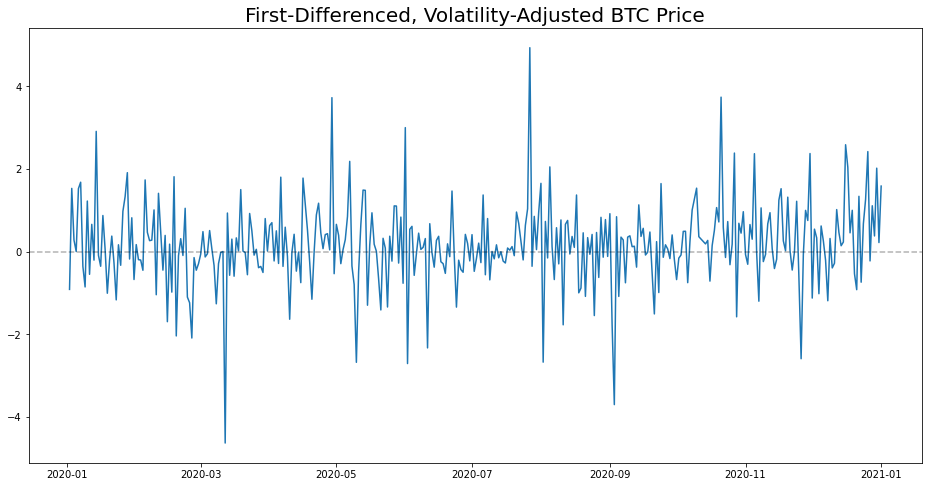

In [286]:
plt.figure(figsize=(16,8))
plt.title("First-Differenced, Volatility-Adjusted BTC Price", fontsize=20)
plt.plot(btc_usd_close_df.Diff_1_v_adj)
plt.axhline(y=0, linestyle='--', color='k', alpha=0.3)

### ADF-Test for First-Differenced, Volatility-Adjusted BTC Price Series

In [287]:
adf_test((btc_usd_close_df.Diff_1 / btc_usd_diff_monthly_vol).dropna())

ADF Statistic: -12.757701
p-value: 0.000000


### ACF for First-Differenced, Volatility-Adjusted BTC Price

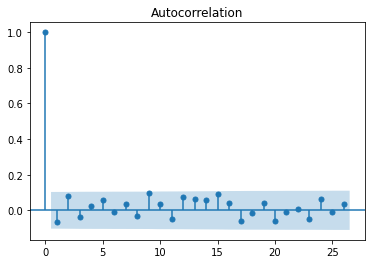

In [288]:
plot_acf((btc_usd_close_df.Diff_1 / btc_usd_diff_monthly_vol).dropna())
plt.show()

### PACF for First-Differenced, Volatility-Adjusted BTC Price

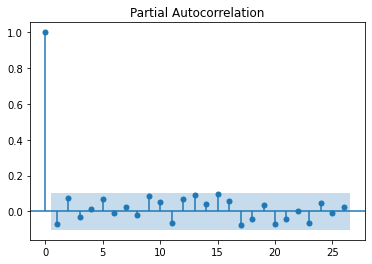

In [289]:
plot_pacf((btc_usd_close_df.Diff_1 / btc_usd_diff_monthly_vol).dropna())
plt.show()

### Percent Change

In [268]:
btc_usd_close_df["Pct_change"] = btc_usd_close_df.Close_n.pct_change().dropna()

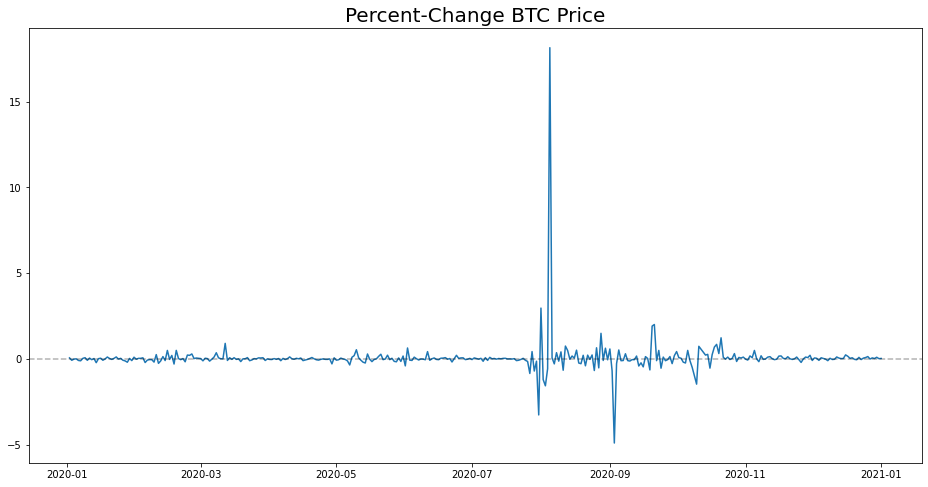

In [269]:
plt.figure(figsize=(16,8))
plt.title("Percent-Change BTC Price", fontsize=20)
plt.plot(btc_usd_close_df.Pct_change)
plt.axhline(y=0, linestyle='--', color='k', alpha=0.3)

### ADF-Test for Percent-Change BTC Price Series

In [270]:
adf_test(btc_usd_close_df.Close_n.pct_change().dropna())

ADF Statistic: -9.310140
p-value: 0.000000


### ACF for Percent-Change BTC Price

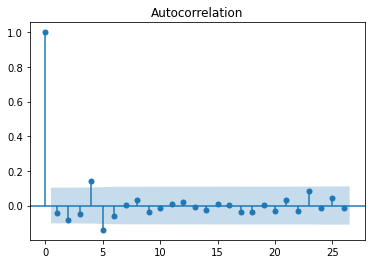

In [271]:
plot_acf(btc_usd_close_df.Close_n.pct_change().dropna())
plt.show()

### PACF for Percent-Change BTC Price

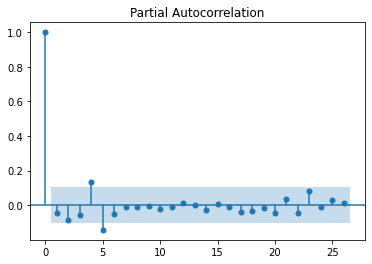

In [272]:
plot_pacf(btc_usd_close_df.Close_n.pct_change().dropna())
plt.show()

### Volatility Adjustment

In [273]:
monthly_pct_std_df = btc_usd_close_df.Pct_change.groupby(btc_usd_close_df.index.month).std()
monthly_pct_std_df

Date
1     0.082474
2     0.195311
3     0.186135
4     0.072206
5     0.177080
6     0.173756
7     0.617720
8     3.341241
9     1.089847
10    0.493260
11    0.129284
12    0.073292
Name: Pct_change, dtype: float64

In [274]:
btc_usd_pct_monthly_vol = btc_usd_close_df.Pct_change.index.month.map(lambda d: monthly_pct_std_df.loc[d])
btc_usd_pct_monthly_vol

Float64Index([0.08247354458060026, 0.08247354458060026, 0.08247354458060026,
              0.08247354458060026, 0.08247354458060026, 0.08247354458060026,
              0.08247354458060026, 0.08247354458060026, 0.08247354458060026,
              0.08247354458060026,
              ...
              0.07329227382983058, 0.07329227382983058, 0.07329227382983058,
              0.07329227382983058, 0.07329227382983058, 0.07329227382983058,
              0.07329227382983058, 0.07329227382983058, 0.07329227382983058,
              0.08247354458060026],
             dtype='float64', name='Date', length=363)

In [283]:
btc_usd_close_df["Pct_change_v_adj"] = (btc_usd_close_df.Pct_change / btc_usd_pct_monthly_vol).dropna()

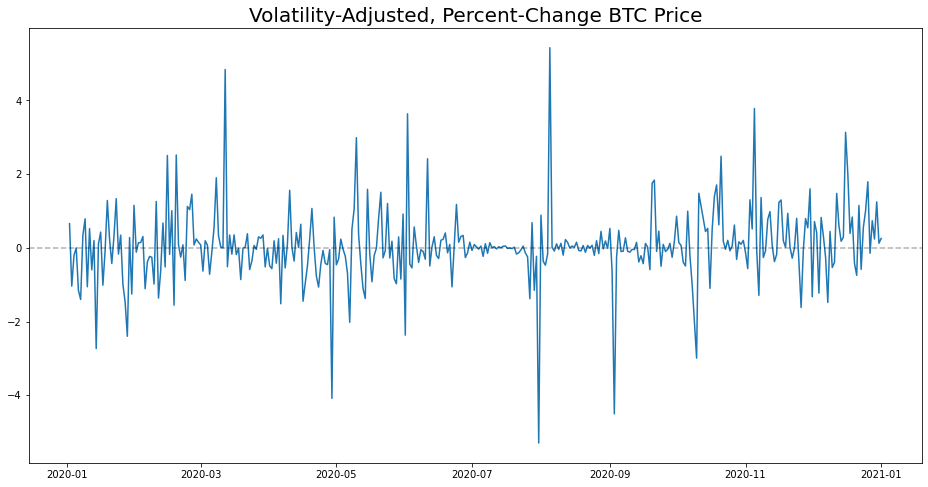

In [284]:
plt.figure(figsize=(16,8))
plt.title("Volatility-Adjusted, Percent-Change BTC Price", fontsize=20)
plt.plot(btc_usd_close_df.Pct_change_v_adj)
plt.axhline(y=0, linestyle='--', color='k', alpha=0.3)

### ADF-Test for Volatility-Adjusted, Percent-Change BTC Price Series

In [282]:
adf_test((btc_usd_close_df.Pct_change / btc_usd_pct_monthly_vol).dropna())

ADF Statistic: -1.932529
p-value: 0.316917


### ACF for Volatility-Adjusted, Percent-Change BTC Price

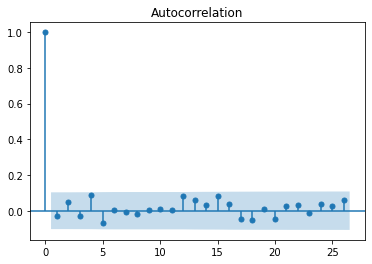

In [278]:
plot_acf((btc_usd_close_df.Pct_change / btc_usd_pct_monthly_vol).dropna())
plt.show()

### PACF for Volatility-Adjusted, Percent-Change BTC Price

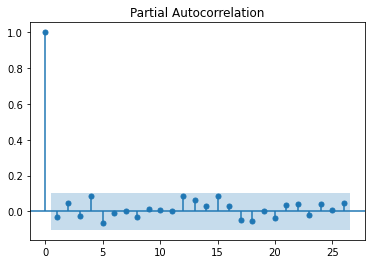

In [279]:
plot_pacf((btc_usd_close_df.Pct_change / btc_usd_pct_monthly_vol).dropna())
plt.show()

## Modeling

### Split Data

In [290]:
# data split
train_end = datetime(2020, 12, 1)

train_pct_data = btc_usd_close_df.Pct_change[:train_end]
train_diff_data = btc_usd_close_df.Diff_1[:train_end]
test_pct_data = btc_usd_close_df.Pct_change[train_end:]
test_diff_data = btc_usd_close_df.Diff_1[train_end:]

### Fit Model

In [292]:
# try arma(5, 5) on percent change
ar5ma5 = ARIMA(train_pct_data, order=(5, 0, 5))
model_fit = ar5ma5.fit()
model_fit.summary()

C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Python39\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Pct_change   No. Observations:                  332
Model:                 ARIMA(5, 0, 5)   Log Likelihood                -494.140
Date:                Thu, 15 Jul 2021   AIC                           1012.281
Time:                        02:59:40   BIC                           1057.942
Sample:                             0   HQIC                          1030.491
                                - 332                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0587      0.054      1.080      0.280      -0.048       0.165
ar.L1          0.0124      1.286      0.010      0.992      -2.508       2.532
ar.L2         -0.0073      0.530     -0.014      0.989      -1.045       1.031
ar.L3          0.2316      0.417      0.555      0.579      -0.586       1.050
ar.L4          0.4132      0.631      0.655      0.512      -0.823       1.649
ar.L5          0.1169      0.726      0.161      0.872      -1.306       1.540
ma.L1         -0.0485      1.302     -0.037      0.970      -2.600       2.503
ma.L2         -0.0722      0.560     -0.129      0.897      -1.169       1.025
ma.L3         -0.2878      0.514     -0.560      0.576      -1.295       0.720
ma.L4         -0.2721      0.702     -0.387      0.698      -1.649       1.104
ma.L5         -0.2229      0.596     -0.374      0.709      -1.392       0.946
sigma2         1.1582      0.039     29.508      0.000       1.081       1.235
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            480435.46
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):              16.69   Skew:                            11.50
Prob(H) (two-sided):                  0.00   Kurtosis:                       187.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [297]:
# try ma(5) on percent change
ma5 = ARIMA(train_pct_data, order=(5, 0, 0))
model_fit = ma5.fit()
model_fit.summary()

C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Pct_change   No. Observations:                  332
Model:                 ARIMA(5, 0, 0)   Log Likelihood                -495.355
Date:                Thu, 15 Jul 2021   AIC                           1004.711
Time:                        03:01:12   BIC                           1031.347
Sample:                             0   HQIC                          1015.333
                                - 332                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0554      0.102      0.543      0.587      -0.144       0.255
ar.L1         -0.0244      0.062     -0.396      0.692      -0.145       0.096
ar.L2         -0.0827      0.053     -1.550      0.121      -0.187       0.022
ar.L3         -0.0577      0.051     -1.125      0.261      -0.158       0.043
ar.L4          0.1256      0.026      4.827      0.000       0.075       0.177
ar.L5         -0.1386      0.022     -6.249      0.000      -0.182      -0.095
sigma2         1.1672      0.026     44.895      0.000       1.116       1.218
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):            489630.68
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):              20.55   Skew:                            11.56
Prob(H) (two-sided):                  0.00   Kurtosis:                       189.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [296]:
# try arma() on first diff.
arma = ARIMA(train_diff_data, order=(5, 0, 0))
model_fit = arma.fit()
model_fit.summary()

C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Diff_1   No. Observations:                  332
Model:                 ARIMA(5, 0, 0)   Log Likelihood                 362.617
Date:                Thu, 15 Jul 2021   AIC                           -711.234
Time:                        03:00:50   BIC                           -684.598
Sample:                             0   HQIC                          -700.612
                                - 332                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0081      0.005      1.628      0.104      -0.002       0.018
ar.L1         -0.0686      0.057     -1.197      0.231      -0.181       0.044
ar.L2         -0.0037      0.053     -0.069      0.945      -0.108       0.101
ar.L3         -0.0751      0.066     -1.130      0.259      -0.205       0.055
ar.L4          0.0605      0.042      1.447      0.148      -0.021       0.142
ar.L5          0.0729      0.062      1.169      0.243      -0.049       0.195
sigma2         0.0065      0.000     30.736      0.000       0.006       0.007
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3590.56
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                            -1.41
Prob(H) (two-sided):                  0.55   Kurtosis:                        18.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [242]:
arma = ARIMA(train_pct_data, order=(0, 0, 29))
model_fit = arma.fit()
model_fit.summary()

C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Pct_change   No. Observations:                 1597
Model:                ARIMA(0, 0, 29)   Log Likelihood               -4311.664
Date:                Thu, 15 Jul 2021   AIC                           8685.327
Time:                        02:33:44   BIC                           8851.979
Sample:                             0   HQIC                          8747.216
                               - 1597                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1566      0.481      0.326      0.745      -0.785       1.098
ma.L1         -0.0039      0.104     -0.038      0.970      -0.207       0.199
ma.L2         -0.0145      0.086     -0.168      0.866      -0.184       0.155
ma.L3          0.0074      0.173      0.043      0.966      -0.331       0.346
ma.L4         -0.0137      0.051     -0.267      0.789      -0.114       0.087
ma.L5          0.0024      0.067      0.037      0.971      -0.128       0.133
ma.L6          0.0521      0.021      2.453      0.014       0.010       0.094
ma.L7          0.0222      0.059      0.374      0.708      -0.094       0.139
ma.L8         -0.0236      0.081     -0.291      0.771      -0.182       0.135
ma.L9          0.0027      0.070      0.038      0.970      -0.134       0.139
ma.L10         0.0204      0.034      0.605      0.545      -0.046       0.086
ma.L11        -0.0002      0.040     -0.005      0.996      -0.078       0.078
ma.L12        -0.0025      0.117     -0.022      0.983      -0.232       0.227
ma.L13        -0.0401      0.021     -1.930      0.054      -0.081       0.001
ma.L14         0.0251      0.027      0.936      0.349      -0.027       0.078
ma.L15         0.0130      0.057      0.228      0.820      -0.099       0.125
ma.L16         0.0263      0.046      0.573      0.567      -0.064       0.116
ma.L17         0.0002      0.149      0.001      0.999      -0.291       0.291
ma.L18        -0.0021      0.090     -0.024      0.981      -0.179       0.175
ma.L19        -0.0318      0.132     -0.240      0.810      -0.291       0.228
ma.L20         0.0994      0.076      1.300      0.193      -0.050       0.249
ma.L21         0.0282      0.025      1.147      0.251      -0.020       0.076
ma.L22        -0.0167      0.044     -0.379      0.704      -0.103       0.069
ma.L23         0.0028      0.080      0.036      0.972      -0.154       0.159
ma.L24         0.0100      0.090      0.111      0.912      -0.167       0.187
ma.L25         0.0244      0.027      0.898      0.369      -0.029       0.078
ma.L26         0.0069      0.119      0.057      0.954      -0.227       0.241
ma.L27         0.0030      0.171      0.017      0.986      -0.333       0.339
ma.L28         0.0084      0.069      0.121      0.903      -0.127       0.143
ma.L29         0.5476      0.018     31.093      0.000       0.513       0.582
sigma2        12.9107      0.129    100.209      0.000      12.658      13.163
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):          83567595.31
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):            1005.92   Skew:                            30.84
Prob(H) (two-sided):                  0.00   Kurtosis:                      1121.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using t

## Predictions

### Rolling Forecast Origin for MA(5)

In [306]:
predictions_ma5 = pd.Series()
for i in range(len(test_pct_data.index)):
    end_date = test_pct_data.index[i]
    data = btc_usd_close_df.Pct_change[:end_date - timedelta(days=1)]
    model = ARIMA(data, order=(0, 0, 5))
    fit = model.fit()
    pred = fit.predict(i)
    predictions_ma5[end_date] = pred[i]

<ipython-input-306-d1b468c8f620>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions_ma5 = pd.Series()


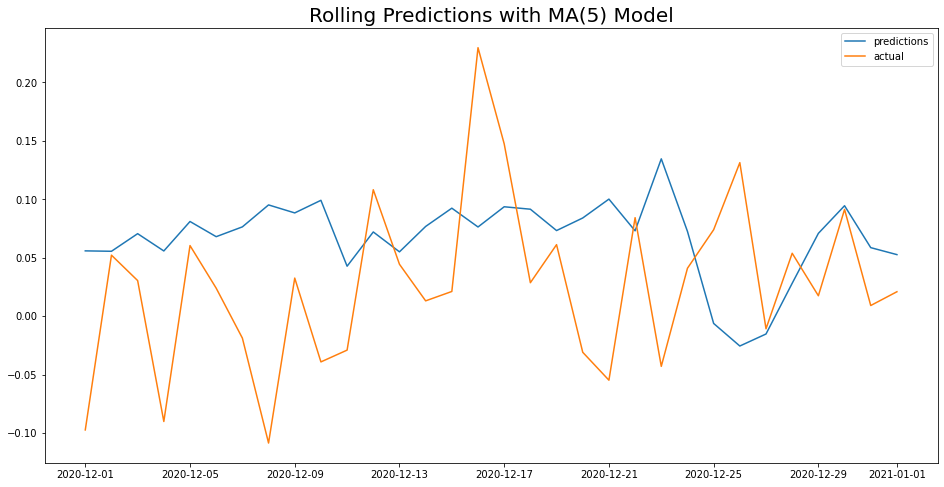

In [307]:
plt.figure(figsize=(16,8))
plt.title("Rolling Predictions with MA(5) Model", fontsize=20)
plt.plot(predictions_ma5, label="predictions")
plt.plot(test_pct_data, label="actual")
plt.legend()

### Residuals for MA(5)

In [308]:
residuals_ma5 = test_pct_data - predictions_ma5

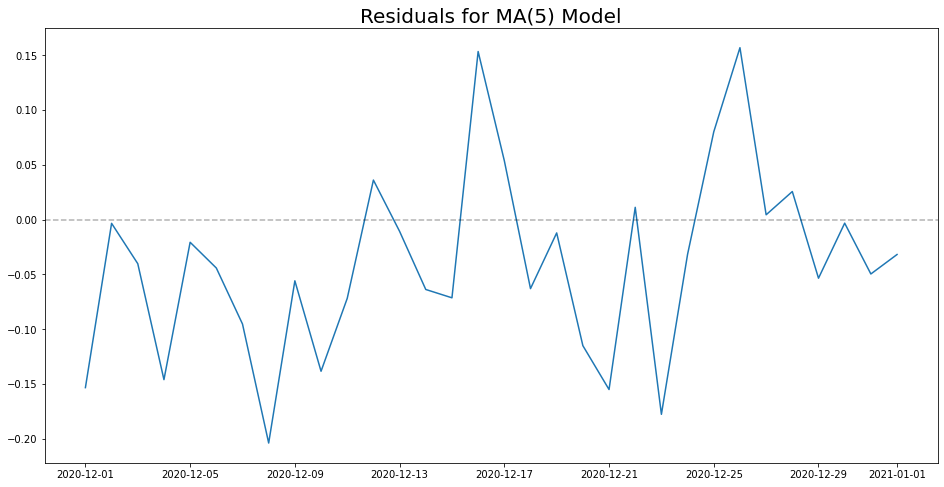

In [309]:
plt.figure(figsize=(16, 8))
plt.title("Residuals for MA(5) Model", fontsize=20)
plt.plot(residuals_ma5)
plt.axhline(y=0, linestyle='--', color='k', alpha=0.3)

### Rolling Forecast Origin for AR(5)

In [314]:
predictions_ar5 = pd.Series()
for i in range(test_pct_data.index.size):
    end_date = test_pct_data.index[i]
    data = btc_usd_close_df.Pct_change[:end_date - timedelta(days=1)]
    model = ARIMA(data, order=(5, 0, 0))
    fit = model.fit()
    pred = fit.predict(i)
    predictions_ar5[end_date] = pred[i]

<ipython-input-314-b4909d0a4923>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions_ar5 = pd.Series()
C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


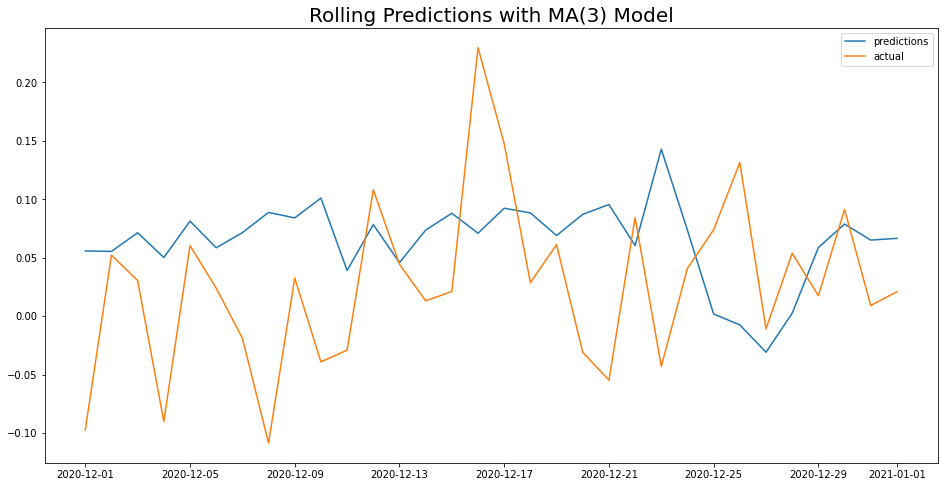

In [315]:
plt.figure(figsize=(16,8))
plt.title("Rolling Predictions with MA(3) Model", fontsize=20)
plt.plot(predictions_ar5, label="predictions")
plt.plot(test_pct_data, label="actual")
plt.legend()

### Residuals for AR(5)

In [316]:
residuals_ar5 = test_pct_data - predictions_ar5

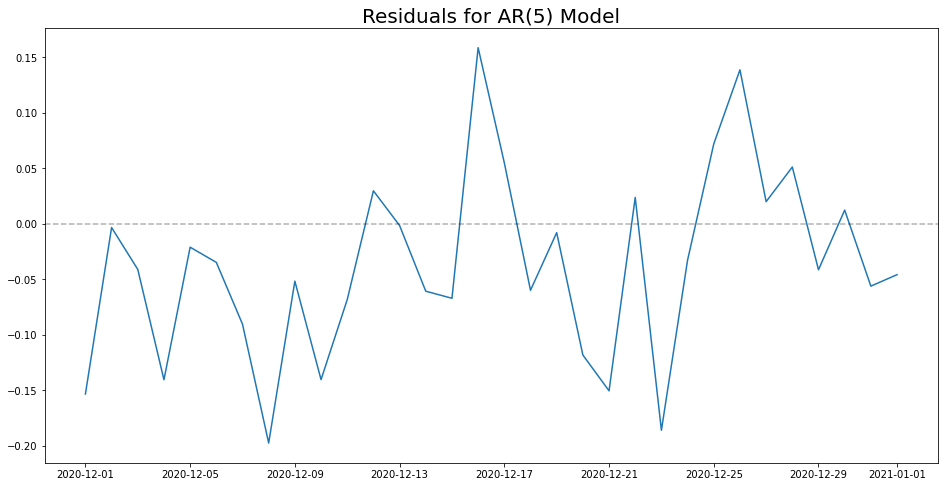

In [318]:
plt.figure(figsize=(16, 8))
plt.title("Residuals for AR(5) Model", fontsize=20)
plt.plot(residuals_ar5)
plt.axhline(y=0, linestyle='--', color='k', alpha=0.3)